In [1]:
import pandas as pd
import numpy as np
import yaml
import seaborn as sns
import os
from os import path
import matplotlib.pyplot as plt
from surprise import Dataset, SVD, Reader
from surprise.model_selection import cross_validate
from surprise.dump import dump
from surprise.dump import load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
%cd ..

c:\Users\CARNOT\movies-recommendation


In [4]:
%pwd

'c:\\Users\\CARNOT\\movies-recommendation'

In [3]:
with open("params.yaml") as f:
    config = yaml.safe_load(f)
    
config

{'paths': {'raw_data': 'data/raw/combined_data_1.txt',
  'movie_title': 'data/raw/movie_titles.csv',
  'interim_cleaning': 'data/interim/data1.csv',
  'clean_data': 'data/processed/data_clean.csv',
  'clean_data_t': 'data/processed/data_clean_transpose.csv',
  'movie_summary': 'data/processed/df_movie_summary.csv',
  'cust_summary': 'data/processed/df_cust_summary.csv'},
 'model': 'models/svd.pkl'}

In [4]:

def parse(file):
    if path.exists(config["paths"]["interim_cleaning"]):
        print("path do exist and it is going to be deleted")
        os.remove(config["paths"]["interim_cleaning"])
    print("loading and empty data1.csv")
    data = open(config["paths"]["interim_cleaning"], mode="w")
    print("parsing the raw file in an order that can be read by pandas")
    with open(file) as f:
        lines = f.readlines()
        for k in range(len(lines)):
            line = lines[k]
            line = line.strip()
            if line.endswith(":"):
                movie_id = line.replace(":", "")
            else:
                row = [x for x in line.split(",")]
                row.insert(0, movie_id)
                data.write(",".join(row))
                data.write("\n")
    print("end of parsing")
    print("loading the parsing data with pandas")
    df_viewmovies = pd.read_csv(config["paths"]["interim_cleaning"], names= ["movie_id", "customer_id", "rating", "ratingdate"])
    print("formatting the columns of the data")
    df_viewmovies["rating"] = df_viewmovies["rating"].astype(np.float32)
    df_viewmovies.ratingdate = pd.to_datetime(df_viewmovies.ratingdate)
    print("resaving the formatted data")
    df_viewmovies.to_csv(config["paths"]["interim_cleaning"], index=False)
    return df_viewmovies

In [5]:
file_path = config["paths"]["raw_data"]
df_viewmovies = parse(file_path)

path do exist and it is going to be deleted
loading and empty data1.csv
parsing the raw file in an order that can be read by pandas
end of parsing
loading the parsing data with pandas
formatting the columns of the data
resaving the formatted data


In [23]:
df_viewmovies["year"] = df_viewmovies.ratingdate.dt.year
df_viewmovies.cnt = 1.0
df_viewmovies.head()

,movie_id,customer_id,rating,ratingdate,year
0,1,1488844,3.0,2005-09-06,2005
1,1,822109,5.0,2005-05-13,2005
2,1,885013,4.0,2005-10-19,2005
3,1,30878,4.0,2005-12-26,2005
4,1,823519,3.0,2004-05-03,2004


In [24]:
df_viewmovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   movie_id     int64         
 1   customer_id  int64         
 2   rating       float32       
 3   ratingdate   datetime64[ns]
 4   year         int64         
dtypes: datetime64[ns](1), float32(1), int64(3)
memory usage: 825.8 MB


In [26]:
df_viewmovies.isna().sum()

movie_id       0
customer_id    0
rating         0
ratingdate     0
year           0
dtype: int64

Text(0.5, 1.0, 'Production per year')

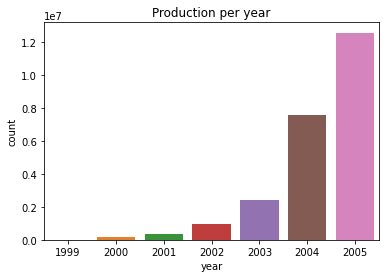

In [29]:
sns.countplot(data=df_viewmovies, x="year")
plt.xlabel("year")
plt.title("Production per year")

In [31]:
del df_viewmovies["year"]

In [32]:
df_viewmovies.columns

Index(['movie_id', 'customer_id', 'rating', 'ratingdate'], dtype='object')

In [7]:
f = ['count','mean']

df_movie_summary = df_viewmovies.groupby('movie_id')['rating'].agg(f)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
keep_movie_list = df_movie_summary[~(df_movie_summary['count'] < movie_benchmark)].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df_viewmovies.groupby('customer_id')['rating'].agg(f)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
keep_cust_list = df_cust_summary[~(df_cust_summary['count'] < cust_benchmark)].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

df_movie_summary.to_csv(config["paths"]["movie_summary"])
df_cust_summary.to_csv(config["paths"]["cust_summary"])

# removing the index in keep_movie_list in keep_cust_list while maintaining the remaining index in the 
# keep_cust_list
# index_to_keep = np.union1d(keep_cust_list, keep_movie_list)
# print(len(index_to_keep))
# del index_to_keep

Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


In [8]:
print('Original Shape: {}'.format(df_viewmovies.shape))
df_viewmovies = df_viewmovies[df_viewmovies.movie_id.isin(keep_movie_list)]
df_viewmovies = df_viewmovies[df_viewmovies.customer_id.isin(keep_cust_list)]
print('After Trim Shape: {}'.format(df_viewmovies.shape))
df_viewmovies.to_csv(config["paths"]["clean_data"], index=False)

Original Shape: (24053361, 4)
After Trim Shape: (13528362, 4)


In [7]:
movie_count_mean = df_viewmovies.groupby("movie_id", as_index=False).aggregate(movie_id_ratingcount=("rating",pd.Series.count), movie_id_ratingmean=("rating", np.mean))

In [8]:
movie_count_mean.head()

,movie_id,movie_id_ratingcount,movie_id_ratingmean
0,8,7195.0,3.124253
1,17,3171.0,2.892778
2,18,8521.0,3.755545
3,26,3418.0,2.751609
4,28,27131.0,3.799786


In [10]:
user_count_mean = df_viewmovies.groupby("customer_id", as_index=False).aggregate(user_id_ratingcount=("rating",pd.Series.count), user_id_ratingmean=("rating", np.mean))

In [11]:
user_count_mean.head()

,customer_id,user_id_ratingcount,user_id_ratingmean
0,6,140.0,3.364286
1,7,190.0,4.068421
2,79,178.0,3.533708
3,97,103.0,3.203883
4,134,160.0,4.737500


df = pd.merge(df_viewmovies, movie_count_mean, on="movie_id")
df = pd.merge(df, user_count_mean, on="customer_id")
df.head()

In [9]:
movies_title = pd.read_csv(config["paths"]["movie_title"], encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
movies_title.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [10]:
df_viewmovies.columns

Index(['movie_id', 'customer_id', 'rating', 'ratingdate'], dtype='object')

In [16]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df_viewmovies[['customer_id', 'movie_id', 'rating']][:100000], reader)

trainer = SVD()

cross_validate(trainer, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9888  0.9808  0.9842  0.9831  0.9867  0.9847  0.0028  
MAE (testset)     0.7921  0.7817  0.7885  0.7800  0.7974  0.7879  0.0065  
Fit time          11.05   11.35   10.89   10.55   9.86    10.74   0.51    
Test time         0.53    0.77    0.35    0.29    0.29    0.45    0.18    


{'test_rmse': array([0.98878068, 0.98079096, 0.98424605, 0.98312602, 0.98668102]),
 'test_mae': array([0.79206549, 0.78170903, 0.788486  , 0.78004017, 0.79739899]),
 'fit_time': (11.054916620254517,
  11.35099983215332,
  10.89100694656372,
  10.549000978469849,
  9.855993747711182),
 'test_time': (0.5330002307891846,
  0.766002893447876,
  0.35399532318115234,
  0.29399895668029785,
  0.28600049018859863)}

In [17]:
trainset = data.build_full_trainset()
trainer.fit(trainset)

In [19]:
dump(config["model"], algo=trainer)

In [11]:
model = load(config["model"])[1]

In [12]:
user_785314 = movies_title.copy()
user_785314.head()


,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [15]:
df_viewmovies.rating.value_counts()

4.0    4609003
3.0    4134310
5.0    2856856
2.0    1386899
1.0     541359
Name: rating, dtype: int64

In [13]:
df_785314 = df_viewmovies[(df_viewmovies['customer_id'] == 785314) & (df_viewmovies['rating'] >= 5)]
df_785314 = df_785314.merge(movies_title, left_on="movie_id", right_on="Movie_Id")[["Movie_Id",'Name']]
df_785314

,Movie_Id,Name
0,175,Reservoir Dogs
1,311,Ed Wood
2,329,Dogma
3,331,Chasing Amy
4,788,Clerks
5,798,Jaws
6,907,Animal Crackers
7,985,The Mummy
8,1552,Black Adder
9,1905,Pirates of the Caribbean: The Curse of the Bla...


In [14]:
user_785314 = movies_title.copy()
user_785314 = user_785314[user_785314['Movie_Id'].isin(keep_movie_list)]
user_785314.head()

,Movie_Id,Year,Name
7,8,2004.0,What the #$*! Do We Know!?
16,17,2005.0,7 Seconds
17,18,1994.0,Immortal Beloved
25,26,2004.0,Never Die Alone
27,28,2002.0,Lilo and Stitch


In [15]:
user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: model.predict(785314, x).est)
user_785314.head()
user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

      Movie_Id    Year                           Name  Estimate_Score
27          28  2002.0                Lilo and Stitch        3.148267
2250      2251  1990.0                     The Rookie        3.011520
3077      3078  1994.0  The Best of Friends: Season 2        3.011520
2991      2992  2003.0                    The Rundown        3.011520
3008      3009  1968.0                   Hellfighters        3.011520
3012      3013  1973.0                      Westworld        3.011520
3014      3015  2004.0                  The Final Cut        3.011520
3016      3017  1985.0                         Cocoon        3.011520
3020      3021  2003.0              House of the Dead        3.011520
3029      3030  2001.0            The Mists of Avalon        3.011520


In [17]:
df_p = pd.pivot_table(data=df_viewmovies, values="rating", columns="movie_id", index="customer_id")
df_p.to_csv(config["paths"]["clean_data_t"])
df_p.head()

movie_id,8,17,18,26,28,30,33,44,46,52,...,4454,4465,4472,4474,4479,4488,4490,4492,4493,4496
customer_id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.0,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,...,NaN,2.0,3.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_p.shape

(95325, 900)

In [19]:
i = int(movies_title.Movie_Id[movies_title['Name'] == "What the #$*! Do We Know!?"])
i

8

In [20]:
df_p[8]

customer_id
6          NaN
7          5.0
79         NaN
97         NaN
134        NaN
          ... 
2649285    NaN
2649296    NaN
2649308    NaN
2649335    NaN
2649336    4.0
Name: 8, Length: 95324, dtype: float32

In [21]:
df_p.corrwith(df_p[8])

movie_id
8       1.000000
17      0.138935
18      0.196853
26      0.133154
28      0.105277
          ...   
4488    0.074197
4490    0.144877
4492    0.194324
4493    0.217294
4496    0.147615
Length: 900, dtype: float64

In [ ]:
df_785314.merge(movies_title, left_on="movie_id", right_on="Movie_Id")[["Movie_Id",'Name']]

In [25]:
def recommend(title, min_count):
    print("For movie ({})".format(title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(movies_title.Movie_Id[movies_title['Name'] == title])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(movies_title.set_index("Movie_Id")).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].reset_index()["Name"].to_dict())

In [26]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
{0: 'What the #$*! Do We Know!?', 1: 'The 10th Kingdom', 2: 'Star Trek: Voyager: Season 5', 3: 'Together', 4: 'Star Trek: Deep Space Nine: Season 5', 5: 'To Gillian on her 37th Birthday', 6: 'Murder on the Orient Express', 7: 'Nausicaa of the Valley of the Wind', 8: 'Star Trek: The Next Generation: Season 5', 9: 'The Life & Death of Peter Sellers'}
